# Trabalho da A2 de Banco de Dados

Integrantes:
- Juan Belieni de Castro Araújo 
- Matheus Medeiros Carvalho da Fonseca

Tema: evolução e estado atual do PIB brasileiro.

## Escolhas dos dados e criação do banco de dados

### GeoData BR

Para possibilitar a visualização dos dados geográficos, utilizamos o projeto do [Geodata BR](https://github.com/tbrugz/geodata-br) para obter os dados de geometria das cidades brasileiras. Esses dados são disponibilizados no formato GeoJson, que ...

No entanto, os dados geográficos necessitam sofrer uma conversão para serem inseridos nos MySQL. Para isso, nós convertemos a coluna `geometry` que existe no GeoDataframe para um formato de texto, que consegue ser lido na hora da inserção no banco de dados.

Conversão dos dados:
```python
data = (row["id"], row["name"], row["geometry"].wkt, row["state_code"])
```

Inserção no banco de dados:
```sql
INSERT INTO cities (id, name, geom, state_code)
VALUES (%s, %s, ST_GeomFromText(%s), %s)
```

### PIB brasileiro

O dataset escolhido para realizar as análises foi o [Produto Interno Bruto do Brasil](https://basedosdados.org/dataset/br-ibge-pib), disponibilizado pelo projeto da [Base dos Dados](https://basedosdados.org/). Foi escolhido essa base pela qualidade dos dados existentes nela, por já está todo padronizado e documentado. Além disso, é utilizado nesse dataset o mesmo número de identificação utilizado pelo projeto do Geodata BR, o ID do IBGE de 7 dígitos, o que facilita na hora de juntar as duas base de dados.

Por estar disponibilizado no formato CSV, a tarefa de inserir no banco criado foi trivial. Para essa finalidade, foi criado uma nova tabela que referencia a tabela que abarca os dados geoespaciais.

## Análises

1. Plot com o PIB por cidade.
2. Plot da participação de cada setor no pib em dois anos distintos no Brasil
3. Quais cidades mais cobram imposto em relação ao pib? (> imposto / pib)

In [1]:
# Importanto os pacotes necessários
import geopandas as gpd
import pandas as pd
import mysql.connector
import matplotlib.pyplot as plt
import matplotlib as mpl

In [4]:
# Conectando ao banco de dados
cnx = mysql.connector.connect(user="root", password="docker", database="brazil", host="mysql")

### Análise 2: plot da participação de cada setor no pib em dois anos distintos no Brasil

In [57]:
# Query para buscar os dados
query = f"""
select cities.name as cidade,
ano,
ST_AsText(geom) as geom,
(va_agropecuaria / va) * 100 as agropecuaria,
(va_industria / va) * 100 as industria,
(va_servicos / va) * 100 as servicos
from pib
inner join cities
on pib.id_municipio = cities.id
where ano in (2002, 2018)
and id_municipio in (
select id_municipio
from pib
where ano in (2002, 2018)
group by id_municipio
having count(*) = 2
)
"""

# Executando a query com o Pandas
df2 = pd.read_sql(query, cnx)

# Convertendo o DataFrame para um GeoDataFrame
df2['geom'] = gpd.GeoSeries.from_wkt(df2['geom'])
df2 = gpd.GeoDataFrame(df2, geometry='geom')

df2.head()

,cidade,ano,geom,agropecuaria,industria,servicos
0,Alta Floresta D'Oeste,2002,"POLYGON ((-62.18209 -11.86686, -62.16230 -11.8...",26.0389,9.0387,23.7620
1,Alta Floresta D'Oeste,2018,"POLYGON ((-62.18209 -11.86686, -62.16230 -11.8...",35.2179,5.5980,26.2210
2,Cabixi,2002,"POLYGON ((-60.39940 -13.45584, -60.40195 -13.4...",36.4012,6.5617,17.1537
3,Cabixi,2018,"POLYGON ((-60.39940 -13.45584, -60.40195 -13.4...",46.2270,3.8405,18.6655
4,Cerejeiras,2002,"POLYGON ((-61.50047 -13.00392, -61.47901 -13.0...",15.8988,9.3719,35.6560


<AxesSubplot:>

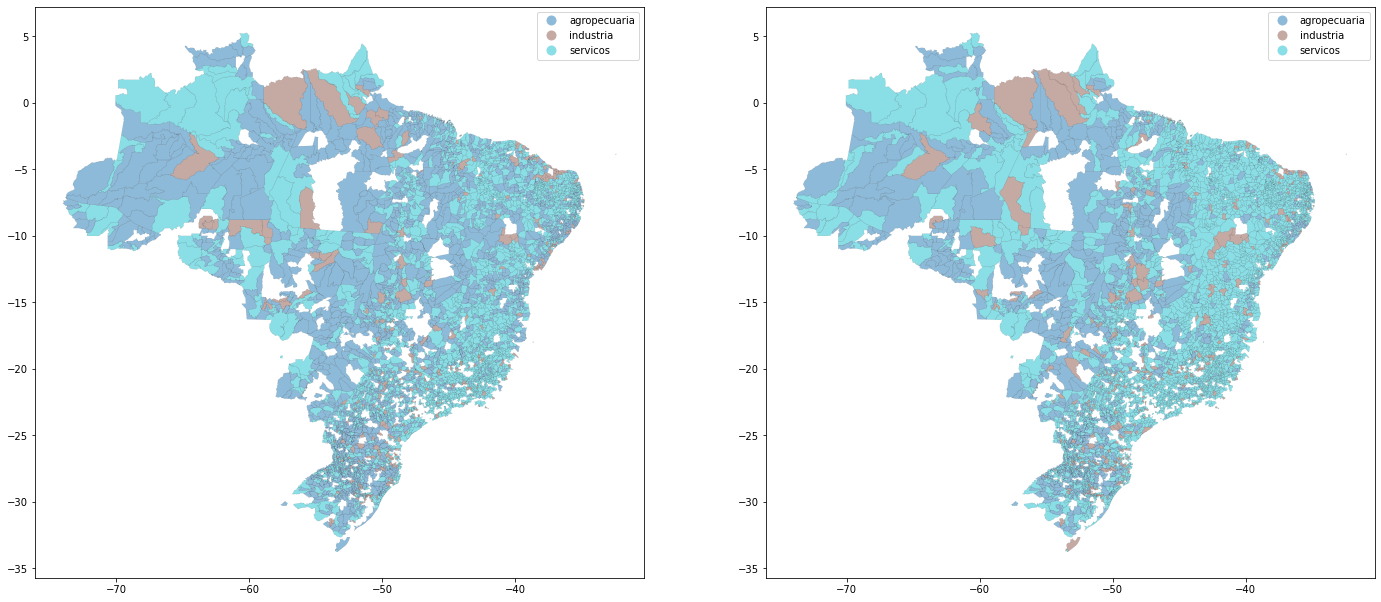

In [56]:
# Criando uma coluna nova para o setor com mais participação
df2['maior_setor'] = df2[['agropecuaria', 'industria', 'servicos']].idxmax(axis=1)

# Plotando 2 mapas com a maior setor em cada ano
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

df2[df2['ano'] == 2002].plot(
    column='maior_setor',
    legend=True,
    ax=ax[0],
    edgecolor='black',
    linewidth=0.1,
    alpha=0.5
)

df2[df2['ano'] == 2018].plot(
    column='maior_setor',
    legend=True,
    ax=ax[1],
    edgecolor='black',
    linewidth=0.1,
    alpha=0.5
)



### Análise 3: quais cidades mais cobram imposto em relação ao pib? (> imposto / pib)

In [71]:
# Query para buscar os dados
query = f"""
select cities.name as cidade,
ano,
ST_AsText(geom) as geom,
(impostos_liquidos / pib) * 100 as impostos,
impostos_liquidos
from pib
inner join cities
on pib.id_municipio = cities.id
"""

# Executando a query com o Pandas
df3 = pd.read_sql(query, cnx)

# Convertendo o DataFrame para um GeoDataFrame
df3['geom'] = gpd.GeoSeries.from_wkt(df3['geom'])
df3 = gpd.GeoDataFrame(df3, geometry='geom')

df3.head()

,cidade,ano,geom,impostos,impostos_liquidos
0,Alta Floresta D'Oeste,2002,"POLYGON ((-62.18209 -11.86686, -62.16230 -11.8...",6.7834,7549266
1,Alta Floresta D'Oeste,2003,"POLYGON ((-62.18209 -11.86686, -62.16230 -11.8...",7.3394,10511613
2,Alta Floresta D'Oeste,2004,"POLYGON ((-62.18209 -11.86686, -62.16230 -11.8...",7.0228,12219047
3,Alta Floresta D'Oeste,2005,"POLYGON ((-62.18209 -11.86686, -62.16230 -11.8...",7.7389,12933774
4,Alta Floresta D'Oeste,2006,"POLYGON ((-62.18209 -11.86686, -62.16230 -11.8...",8.0974,13668803


<AxesSubplot:>

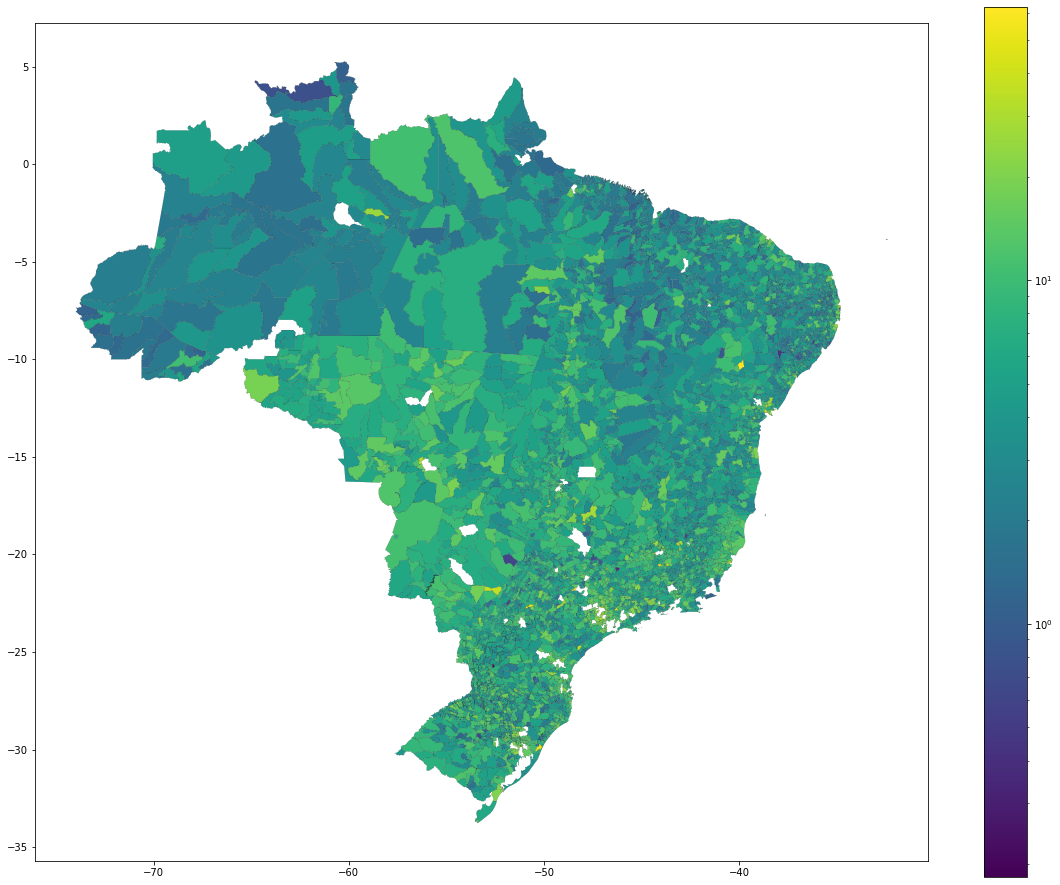

In [82]:
# Plotando o mapa com a porcentagem de impostos
df3_2002 = df3[df3['ano'] == 2002]
impostos = df3_2002['impostos']

df3[df3['ano'] == 2002].plot(
    column='impostos',
    legend=True,
    figsize=(20, 16),
    edgecolor='black',
    linewidth=0.1,
    norm=mpl.colors.LogNorm(vmin=impostos.min(), vmax=impostos.max())
)